In [1]:
####################################Import and Install Package Needed###########################################

import pandas as pd
import numpy as np
from scipy import stats
import argparse
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from data_preparation import *
from price_prediction import *

In [3]:
###########################################Set hyperparameters###################################################

###########################################Set hyperparameters###################################################

# Create the parser
parser = argparse.ArgumentParser(description="argument parser for preprocessing and downloading data")

#timing intervals
parser.add_argument("--start_date", type=str, default = None, help="start date of all data")
parser.add_argument("--days", type=int, default = 500, help="number of days needed")
parser.add_argument("--room_na", type=int, default = 200, help="room of na days")
parser.add_argument("--interval", type=str, default = "1d", choices=["1d","1wk","1mo"], help="choose an interval")
parser.add_argument("--end_date", type=str, default = str(date.today()) , help="end date of all data")

#stock needed
parser.add_argument("--stock", action="store_true", default = 'AAPL' , help = "stock to consider download")

#log indicaters
parser.add_argument("--need_log", action="store_false", help="check if log transformation needed")

#finta indicaters without params
parser.add_argument("--need_ta", action="store_false", help="check if ta indicaters needed")
parser.add_argument("--choices_ta", default = "['RSI','STOCH']", help="choices of ta indicaters")

#trend indicaters
parser.add_argument("--need_macd", action="store_false", help="check if macd indicaters needed")
parser.add_argument("--columns_macd", default = "['Close']" , help="target column of macd")
parser.add_argument("--short_span", type = int, default = 12 , help="short span of macd")
parser.add_argument("--long_span", type = int, default = 26 , help="long span of macd")
parser.add_argument("--signal_span", type = int, default = 9 , help="signal span of macd")

#ema indicaters
parser.add_argument("--need_ema", action="store_false", help="check if ema indicaters needed")
parser.add_argument("--days_ema", default = "[5,15,25,50]" , help="days of ema installed")
parser.add_argument("--columns_ema", default = "['Close']" , help="target column of ema")

#prev day
parser.add_argument("--need_prev", action="store_false", help="check if previous day indicaters needed")
parser.add_argument("--columns_prev", default = "['Close']" , help="target column of previous day")
parser.add_argument("--days_prev", type = int, default = "20" , help= "number of previous days needed")

#shift target
parser.add_argument("--shift_target", action="store_false", help="check if shifting target for backtesting is needed")
#task definition
parser.add_argument("--regression", action = 'store_false', help="to do regression or classification task")
parser.add_argument("--training_size", type = int, default = 300, help = "number of days to used for traning the model" )
parser.add_argument("--training_interval", type = int,  default = 1, help = 'interval to train a new model for each testing day')

#data preprocessing
parser.add_argument("--return_normalization", action = 'store_true', help="to do return rate normalization or not")
parser.add_argument("--min_max_normalization", action = 'store_true', help="to do min max normalization or not" )
parser.add_argument("--standard_normalization", action = 'store_false', help = "to do standard normalization or not"  )

#sequential
parser.add_argument("--sequential", action = 'store_true', help="using sequential model or  not")
parser.add_argument("--window_size", type = int, default = 20, help="using sequential model or  not")
parser.add_argument("--model", default = 'Conv', help="model to use for training")
parser.add_argument("--model_param", default = {}, help = 'model hyperparamters')




In [4]:
################################################Pre-defined Function########################################################

def calculate_final_accum_return(length, k):
  '''with a given parameter k, conduct linear regression and gives the final accumulate return
  '''
  final_accum_return = 1
  flex_strat = np.nan
  daily_return = 0

  signal_list = [1/2*(long_short_accum_return[i]+buy_hold_accum_return[i]) for i in range(length)]
  for j in range(1,length):
    signal_0 = signal_list[j-2]
    signal_1 = signal_list[j-1]
    x = list(range(max(j - k, 0), j))
    y = signal_list[max(j - k, 0):j]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    criteria_1 = slope * (j - 1) + intercept
    criteria_0 = slope * j + intercept

    if signal_1 <= criteria_1 and signal_0 > criteria_0: #go up
      flex_strat = 'ls' if long_short_accum_return[j-1] >= buy_hold_accum_return[j-1] else 'bh'
    elif signal_1 >= criteria_1 and signal_0 < criteria_0: #go down
      flex_strat = 'ls' if long_short_accum_return[j-1] <= buy_hold_accum_return[j-1] else 'bh'
    else: #no change
      flex_strat = flex_strat

    if flex_strat == 'ls':
      daily_return = long_short_daily_return[j]
    elif flex_strat == 'bh':
      daily_return = buy_hold_daily_return[j]
    else: #np.nan
      daily_return = 0

    final_accum_return *= 1 + daily_return

  return final_accum_return, flex_strat, daily_return



def optimize_k(length):
  '''find the best sample size for linear regression to maximize final accumulate return
  '''
  best_parameter_value = None
  best_accum_rate = 0

  for parameter_value in range(1, 100):  # You can adjust the range of parameter values to search
    accum_rate = calculate_final_accum_return(length=length, k=parameter_value)[0]
    if accum_rate > best_accum_rate:
        best_accum_rate = accum_rate
        best_parameter_value = parameter_value
  return best_parameter_value

In [6]:
################################################Trading Strategy########################################################

#read data
data = data_downloader(args)
main_data = predict(args,data)
main_data.set_index('Date', inplace=True)
main_data = main_data.tail(args.test_day)
first_index_prediction = main_data.index[0]
last_index_prediction = main_data.index[-1]

print(f'The test period starts from {first_index_prediction} to {last_index_prediction}, {args.test_day} trading days in total')

main_data.head()

The test period starts from 1 to 355, 355 trading days in total


,Open,High,Low,Volume,log_Open,log_High,log_Low,log_Close,log_Adj Close,log_Volume,...,Close_7,Close_6,Close_5,Close_4,Close_3,Close_2,Close_1,Close_0,Shift_Close,prediction
1,177.839996,178.029999,174.399994,103049300.0,5.180884,5.181952,5.161351,5.162555,5.153784,18.450718,...,168.820007,170.210007,174.070007,174.720001,175.600006,178.960007,177.770004,174.610001,174.309998,174.911199
2,174.029999,174.880005,171.940002,78751300.0,5.159228,5.164100,5.147146,5.160835,5.152064,18.181805,...,170.210007,174.070007,174.720001,175.600006,178.960007,177.770004,174.610001,174.309998,178.440002,168.422651
3,174.570007,178.490005,174.440002,76468400.0,5.162326,5.184533,5.161581,5.184252,5.175481,18.152388,...,174.070007,174.720001,175.600006,178.960007,177.770004,174.610001,174.309998,178.440002,175.059998,177.183155
4,177.500000,178.300003,174.419998,73401800.0,5.178971,5.183468,5.161466,5.165129,5.156358,18.111459,...,174.720001,175.600006,178.960007,177.770004,174.610001,174.309998,178.440002,175.059998,171.830002,171.818297
5,172.360001,173.630005,170.130005,89058800.0,5.149585,5.156927,5.136563,5.146506,5.137734,18.304807,...,175.600006,178.960007,177.770004,174.610001,174.309998,178.440002,175.059998,171.830002,172.139999,170.611772


In [7]:
#final data holder
long_short_accum_return = []
long_short_daily_return = []
long_short_trading_direction = [] #1 for long, -1 for short, 0 for no trading

buy_hold_accum_return = []
buy_hold_daily_return = []
buy_hold_trading_direction = [] #1 for long, -1 for short, 0 for no trading

flexible_accum_return = []
flexible_daily_return = []
flexible_strategy = [] #ls or bh or na
flexible_trading_direction = [] #1 for long, -1 for short, 0 for no trading

signal = []
k_list = []

#set initials
ls_accum = bh_accum = flex_accum = 1
ls_daily = bh_daily = flex_daily = 0
ls_direction = bh_direction = 1
flex_strat = flex_direction = np.nan

In [8]:
for day in tqdm(range(args.test_day)):
  pred_value = main_data.iloc[day, main_data.columns.get_loc('prediction')]
  prev_value = main_data.iloc[day, main_data.columns.get_loc('Close_0')]
  true_value = main_data.iloc[day, main_data.columns.get_loc('Shift_Close')]

  #long short strategy
  if pred_value > prev_value: #long
    ls_daily = (true_value - prev_value)/prev_value
    ls_direction = 1
  elif pred_value < prev_value: #short
    ls_daily = (prev_value - true_value)/prev_value
    ls_direction = -1
  else: #no trading
    ls_daily = 0
    ls_direction = 0

  ls_accum *= 1 + ls_daily

  long_short_accum_return.append(ls_accum)
  long_short_daily_return.append(ls_daily)
  long_short_trading_direction.append(ls_direction)

  #buy hold strategy
  bh_daily = (true_value - prev_value)/prev_value
  bh_accum *= 1 + bh_daily
  bh_direction = 1

  buy_hold_accum_return.append(bh_accum)
  buy_hold_daily_return.append(bh_daily)
  buy_hold_trading_direction.append(bh_direction)

  #print(f'today is {main_data.index[day]}, close price is {prev_value}, prediction value is {pred_value}')
  #print(f'LS decides to {ls_direction}')

  #flexible strategy
  signal.append(1/2 * (ls_accum + bh_accum))

  temp_k = max(optimize_k(length = day-1),2)

  flex_strat = calculate_final_accum_return(length=day, k=temp_k)[1]
  #print(f'decision based on {main_data.index[day-2]} and {main_data.index[day-1]}, flex strat for {main_data.index[day]} is {flex_strat}')
  if flex_strat is np.nan:
    flex_daily = 0
    flex_direction = 0
  else:
    flex_daily = ls_daily if  flex_strat == 'ls'  else bh_daily
    flex_direction = ls_direction if  flex_strat == 'ls'  else bh_direction
  flex_accum *= 1 + flex_daily

  k_list.append(temp_k)
  flexible_accum_return.append(flex_accum)
  flexible_daily_return.append(flex_daily)
  flexible_strategy.append(flex_strat)
  flexible_trading_direction.append(flex_direction)


  0%|          | 0/355 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
100%|██████████| 355/355 [14:04<00:00,  2.38s/it]


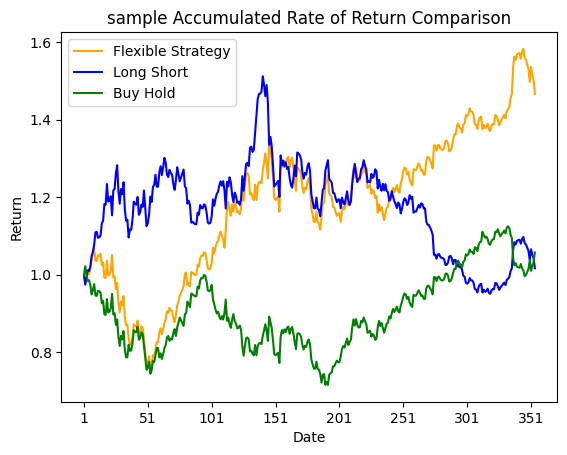

In [9]:
################################################Plot########################################################


X = main_data.index.tolist()
ticker = args.data_loc.split('.')[0]

plt.plot(X, flexible_accum_return,label='Flexible Strategy', color='orange')
plt.plot(X, long_short_accum_return, label='Long Short', color='blue')
plt.plot(X, buy_hold_accum_return, label='Buy Hold', color='green')
#plt.plot(X, signal, color = 'red')

plt.xlabel('Date')
plt.ylabel('Return')
plt.title(f'{ticker} Accumulated Rate of Return Comparison')

# Get the positions and labels for the ticks
x_positions = X[::50]
x_labels = [str(val) for val in x_positions]

# Set the x-ticks with the calculated positions and labels
plt.xticks(x_positions, x_labels)


# Add a legend
plt.legend()

plt.show()


In [12]:
################################################Performance Report########################################################
#check equal length
#print(len(main_data.index), len(long_short_daily_return), len(long_short_accum_return), len(long_short_trading_direction), len(buy_hold_daily_return), len(buy_hold_accum_return),len(buy_hold_trading_direction))
report_data = {'Date': main_data.index, 'LS daily return': long_short_daily_return, 'LS accumulate return': long_short_accum_return, 'LS direction':long_short_trading_direction, 'BH daily return': buy_hold_daily_return, 'BH accumulate return': buy_hold_accum_return,'BH direction':buy_hold_trading_direction\
               , 'Flex daily return': flexible_daily_return, 'Flex accumulate return': flexible_accum_return, 'Flex direction': flexible_trading_direction, 'Flex strategy': flexible_strategy\
               ,'k':k_list}
report_df = pd.DataFrame(report_data)
report_df.head(20)



,Date,LS daily return,LS accumulate return,LS direction,BH daily return,BH accumulate return,BH direction,Flex daily return,Flex accumulate return,Flex direction,Flex strategy,k
0,1,-0.001718,0.998282,1,-0.001718,0.998282,1,0.000000,1.000000,0,NaN,2
1,2,-0.023693,0.974629,-1,0.023693,1.021935,1,0.000000,1.000000,0,NaN,2
2,3,0.018942,0.993091,-1,-0.018942,1.002577,1,0.000000,1.000000,0,NaN,2
3,4,0.018451,1.011414,-1,-0.018451,0.984079,1,0.000000,1.000000,0,NaN,2
4,5,-0.001804,1.009589,-1,0.001804,0.985854,1,0.001804,1.001804,1,bh,2
5,6,0.011909,1.021612,-1,-0.011909,0.974114,1,0.011909,1.013735,-1,ls,2
6,7,0.025516,1.047680,-1,-0.025516,0.949258,1,0.025516,1.039601,-1,ls,2
7,8,0.011523,1.059752,1,0.011523,0.960197,1,0.011523,1.051581,1,bh,2
8,9,0.016343,1.077071,1,0.016343,0.975889,1,0.016343,1.068766,1,bh,2
9,10,0.029988,1.109371,-1,-0.029988,0.946624,1,-0.029988,1.036716,1,bh,2


In [ ]:
report_df.to_csv(f'{ticker} performance report ({first_index_prediction} to {last_index_prediction}).csv')
